In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir(globals()['_dh'][0])
os.chdir('..')
# print(os.path.abspath(os.curdir))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import rfcutils

No CUDA device found; using CPU as fallback.


2025-04-03 13:02:30.507942: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-04-03 13:02:30.507969: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-03 13:02:30.507978: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-03 13:02:30.508009: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-03 13:02:30.508021: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
import os
os.environ["MITSUBA_VARIANT"] = "llvm_ad_rgb"
import sionna


In [20]:


# 1) Quick look at top-level attributes
print(dir(sionna))

# 2) Full docstring summary
help(sionna.utils.tensors)


['ALPHA_MAX', 'BOLTZMANN_CONSTANT', 'DIELECTRIC_PERMITTIVITY_VACUUM', 'H', 'PI', 'SPEED_OF_LIGHT', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'channel', 'config', 'constants', 'fec', 'mapping', 'mimo', 'nr', 'ofdm', 'rt', 'signal', 'utils']
Help on module sionna.utils.tensors in sionna.utils:

NAME
    sionna.utils.tensors - Functions extending TensorFlow tensor operations

FUNCTIONS
    expand_to_rank(tensor, target_rank, axis=-1)
        Inserts as many axes to a tensor as needed to achieve a desired rank.
        
        This operation inserts additional dimensions to a ``tensor`` starting at
        ``axis``, so that so that the rank of the resulting tensor has rank
        ``target_rank``. The dimension index follows Python indexing rules, i.e.,
        zero-based, where a negative index is counted backward from the end.
        
        Args:
            tensor : A tensor.
            targe

In [21]:
testset_identifier = 'TestSet1Example'
soi_type, interference_sig_type = 'QPSK', 'EMISignal1'
all_sig_mixture = np.load(os.path.join('dataset', f'{testset_identifier}_testmixture_{soi_type}_{interference_sig_type}.npy'))
meta_data = np.load(os.path.join('dataset', f'{testset_identifier}_testmixture_{soi_type}_{interference_sig_type}_metadata.npy'))
# For TestSet1Example
all_sig_mixture_groundtruth, all_sig1, all_bits1 = pickle.load(open(os.path.join('dataset', f'GroundTruth_{testset_identifier}_Dataset_{soi_type}_{interference_sig_type}.pkl'), 'rb'))

In [4]:
testset_identifier = 'Training_Dataset'
soi_type, interference_sig_type = 'BASEBAND_CW_SOI', 'BASEBAND_CW_INTERFERENCE'
all_sig_mixture = np.load(os.path.join('dataset', f'{testset_identifier}_{soi_type}_{interference_sig_type}.npy'))
meta_data = np.load(os.path.join('dataset', f'{testset_identifier}_testmixture_{soi_type}_{interference_sig_type}_metadata.npy'))
# For TestSet1Example
all_sig_mixture_groundtruth, all_sig1, all_bits1 = pickle.load(open(os.path.join('dataset', f'GroundTruth_{testset_identifier}_Dataset_{soi_type}_{interference_sig_type}.pkl'), 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/Training_Dataset_BASEBAND_CW_SOI_BASEBAND_CW_INTERFERENCE.npy'

In [22]:
example_idx = 0

/opt/anaconda3/envs/icassp24-rf/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/icassp24-rf/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


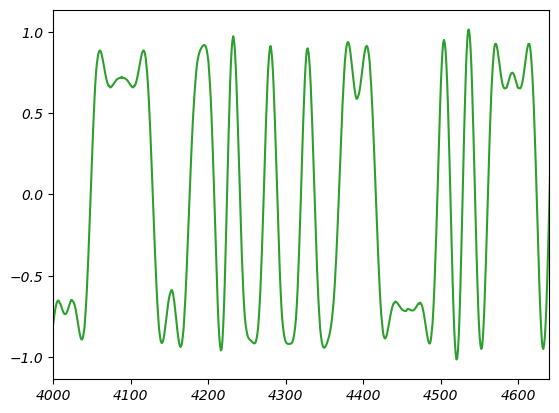

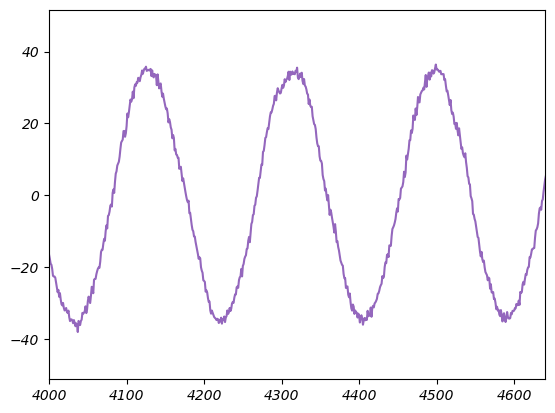

In [23]:
plt.figure()
plt.plot(all_sig1[example_idx], color='tab:green')
plt.xlim([4000, 4640])
plt.show()

plt.figure()
plt.plot(all_sig_mixture[example_idx], color='tab:purple')
plt.xlim([4000, 4640])
plt.show()

In [24]:
sig_len = 40960
def get_soi_generation_fn(soi_sig_type):
    if soi_sig_type == 'QPSK':
        generate_soi = lambda n, s_len: rfcutils.generate_qpsk_signal(n, s_len//16)
        demod_soi = rfcutils.qpsk_matched_filter_demod
    elif soi_sig_type == 'QAM16':
        generate_soi = lambda n, s_len: rfcutils.generate_qam16_signal(n, s_len//16)
        demod_soi = rfcutils.qam16_matched_filter_demod
    elif soi_sig_type ==  'QPSK2':
        generate_soi = lambda n, s_len: rfcutils.generate_qpsk2_signal(n, s_len//4)
        demod_soi = rfcutils.qpsk2_matched_filter_demod
    elif soi_sig_type == 'OFDMQPSK':
        generate_soi = lambda n, s_len: rfcutils.generate_ofdm_signal(n, s_len//80)
        _,_,_,RES_GRID = rfcutils.generate_ofdm_signal(1, sig_len//80)
        demod_soi = lambda s: rfcutils.ofdm_demod(s, RES_GRID)
    else:
        raise Exception("SOI Type not recognized")
    return generate_soi, demod_soi

generate_soi, demod_soi = get_soi_generation_fn(soi_type)

In [25]:
bits_demod, syms_demod = demod_soi(all_sig1[example_idx:example_idx+1]) # retain the shape, axis=0 should be the mixture index
np.allclose(bits_demod, all_bits1[example_idx:example_idx+1])

True

### Baseline Curves with TestSet1Example

In [26]:
all_sinr = np.arange(-30, 0.1, 3)
n_per_batch = 100

def run_demod_test(sig1_est, bit1_est, soi_type, interference_sig_type, testset_identifier):
    # For SampleEvalSet
    all_sig_mixture_groundtruth, all_sig1, all_bits1 = pickle.load(open(os.path.join('dataset', f'GroundTruth_{testset_identifier}_Dataset_{soi_type}_{interference_sig_type}.pkl'), 'rb'))
    
    # Evaluation pipeline
    def eval_mse(all_sig_est, all_sig_soi):
        assert all_sig_est.shape == all_sig_soi.shape, 'Invalid SOI estimate shape'
        return np.mean(np.abs(all_sig_est - all_sig_soi)**2, axis=1)
    
    def eval_ber(bit_est, bit_true):
        ber = np.sum((bit_est != bit_true).astype(np.float32), axis=1) / bit_true.shape[1]
        assert bit_est.shape == bit_true.shape, 'Invalid bit estimate shape'
        return ber

    all_mse, all_ber = [], [] 
    for idx, sinr in enumerate(all_sinr):
        batch_mse =  eval_mse(sig1_est[idx*n_per_batch:(idx+1)*n_per_batch], all_sig1[idx*n_per_batch:(idx+1)*n_per_batch])
        bit_true_batch = all_bits1[idx*n_per_batch:(idx+1)*n_per_batch]
        batch_ber = eval_ber(bit1_est[idx*n_per_batch:(idx+1)*n_per_batch], bit_true_batch)
        all_mse.append(batch_mse)
        all_ber.append(batch_ber)

    all_mse, all_ber = np.array(all_mse), np.array(all_ber)
    mse_mean = 10*np.log10(np.mean(all_mse, axis=-1))
    ber_mean = np.mean(all_ber, axis=-1)
    return mse_mean, ber_mean

In [28]:
testset_identifier = 'TestSet1Example'
for soi_type in ['QPSK', 'EMISignal1']:
    for interference_sig_type in ['EMISignal1', 'CommSignal2', 'CommSignal3', 'CommSignal5G1']:

        all_mse, all_ber = {}, {}
        for id_string in ['Default_NoMitigation', 'Default_LMMSE', 'Default_TF_UNet', 'Default_Torch_WaveNet']:
            sig1_est = np.load(os.path.join('outputs', f'{id_string}_{testset_identifier}_estimated_soi_{soi_type}_{interference_sig_type}.npy'))
            bit1_est = np.load(os.path.join('outputs', f'{id_string}_{testset_identifier}_estimated_bits_{soi_type}_{interference_sig_type}.npy'))
            mse_mean, ber_mean = run_demod_test(sig1_est, bit1_est, soi_type, interference_sig_type, testset_identifier)
            all_mse[id_string] = mse_mean
            all_ber[id_string] = ber_mean

        plt.figure()
        for id_string in all_mse.keys():
            plt.plot(all_sinr, all_mse[id_string], 'x--', label=id_string)
        plt.legend()
        plt.grid()
        plt.gca().set_ylim(top=3)
        plt.xlabel('SINR [dB]')
        plt.ylabel('MSE [dB]')
        plt.title(f'MSE - {soi_type} + {interference_sig_type}')
        plt.show()

        plt.figure()
        for id_string in all_ber.keys():
            plt.semilogy(all_sinr, all_ber[id_string], 'x--', label=id_string)
        plt.legend()
        plt.grid()
        plt.ylim([1e-4, 1])
        plt.xlabel('SINR [dB]')
        plt.ylabel('BER')
        plt.title(f'BER - {soi_type} + {interference_sig_type}')
        plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/Default_NoMitigation_TestSet1Example_estimated_soi_QPSK_EMISignal1.npy'